**This notebook uses the Matlab kernel. You need to have matlab_kernel installed and enable communication between Matlab and Juypter Notebook on your system. You can find instructions how to do it [here](https://am111.readthedocs.io/en/latest/jmatlab_install.html).**

We will be working with a small audio file. It is an excerpt of a whale song made available by the [Alaska Whale Foundation](https://www.alaskawhalefoundation.org/). Do check out their website to learn more and for breathtaking imagery!

In [1]:
[x, sr] = audioread('data/whale_singing_excerpt.wav');

The audio file is around 5.2 seconds long, sampled at 16kHz. 

audioread returns the sampled data as an array (with values between -1 and 1), along with the sampling rate.

In [2]:
size(x)


ans =

       84212           1



In [3]:
sr


sr =

       16000



We can listen to the audio sample straight from our browser!

In [4]:
sound(x, sr)

Let's plot the first 100 sampled values.

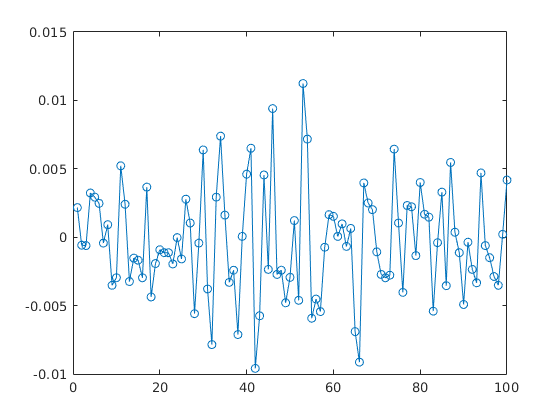

In [5]:
plot(x(1:100, :), '-o')

One of the most common ways of visualizing a sound are spectograms. This is what a conventional (linear-frequency) spectogram would look like.

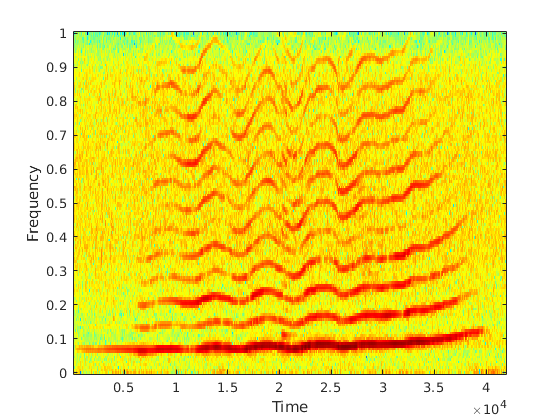

In [6]:
specgram(x)

Clearly there are things that are off with the plot above - the time is off (our signal is 5.2 seconds long) and it is hard to say what is the meaning of the `y` axis.

Insead of looking deeper at `specgram`, let us focus on linear reassignment as defined in `reassignmentgw.m`.

This function takes in a signal, performs reassignment as outlined in the [Sparse Time-Frequency Representations paper](https://doi.org/10.1073/pnas.0601707103) and returns a spectogram.

The function uses a natural coordinate system. Time in samples is 1 to N where N is the count of samples in our signal. Frequency is 0 to 1. In order to reconstruct the real units, time has to be divided by the sampling rate, and frequency gets multiplied by the sampling rate.

The trickiest parameter to understand is `q`, the Q of the wavelet. In the words of the discoverer of the method, Marcelo O. Magnasco:

>The Q of a wavelet is the quotient between its temporal and frequency extent. Our wavelets are ellipses in time-frequency space, their aspect ratio is Q. If Q is >> 1 then the wavelet is frequencylike — it looks like a long oscillation. If Q<<1 then it is timelike, it looks like an impulse in TF space. At 1 it’s a circle in natural units. This code is keeping the Q of the wavelet constant as opposed to keeping the temporal width of the wavelet constant, so the width is reduced at higher frequencies in direct proportion — the wavelets all look identical, just rescaled. 

## Paremeters overview

|parameter|description|
|:------:|:-----------|
|x       |signal, an array of sampled amplitudes with values in the interval -1 and 1| 
|q       |wavelet's Q, defines the wavelet that will be used to analyze the data<br><br>Altering this parameter, utilizing wavelets of different temporal to frequency extent ratios (different shapes in the time-frequency space), will allow us to zoom in on different aspects of the data. On one extreme, we can follow tone like sounds, on the other click-like sounds. Good values to try when working with tonal sounds are 2, 4, 8 and 1 and 0.5 for impulsive sounds.|
|tdeci   |decimation parameter, how many samples are skipped horizontally<br><br>A signal with 1000 samples and a tdeci of 10 will produce a picture that is 100 pixels wide. The higher the value, tha narrower the picture.|
|over    |oversampling (number of frequencies tried per vertical pixel)<br><br>We oversample frequencies when we make more scan lines than pixels. So if over=5, and our picture is 500 pixels tall, then we will generate 2500 reassignment transforms.|
|noct    |number of divisions per octave (frequency stride in log freq)<br><br>We are scanning frequency in log scale like a piano keyboard, noct is the number of divisions per octave. A piano keyboard has noct=12, or 12 keys per octave.|
|minf    |the smallest frequency to visualize|
|maxf    |the largest frequency to visualize<br><br>The spectogram is symmetric with respect to 0.5 (the nyquist frequency) so maxf should usually be <= 0.5|

## Return value
The returned spectogram has the frequency in log units. It will be of shape:
```
twidth= total samples/tdeci (rounded+1)
fwidth= log2(maxf/minf)*noct (rounded+1)
```

**Note:** Most of the parameter descriptions above come from the function body or personal communication with the discoverer of the method, Marcelo O. Magnasco. I am extremely grateful for the help that he has showed me in understanding the behavior of linear reassignment.

Let's experiment with various parameter values and take a look at the results.

In [7]:
q = 1;
tdeci = 300;
over = 2;
noct = 100;
minf = 0.02;
maxf = 0.06;
result = reassignmentgw(x, q, tdeci, over, noct, minf, maxf);

done_reassignment in 3.8424 s


In [8]:
size(result)


ans =

   281   160



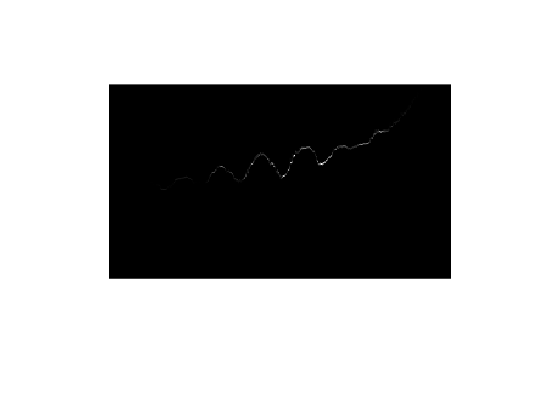

In [9]:
imshow(full(result).', [0, max(full(result), [], 'all')])

Around 17% elements of the resultant array are non-zero.

Can we reduce the horizontal stride, skip less samples between performing calculations?

In [10]:
noct = 300; % earlier we were dividing an octave into 100 frequencies
result = reassignmentgw(x, q, tdeci, over, noct, minf, maxf);

done_reassignment in 11.4377 s


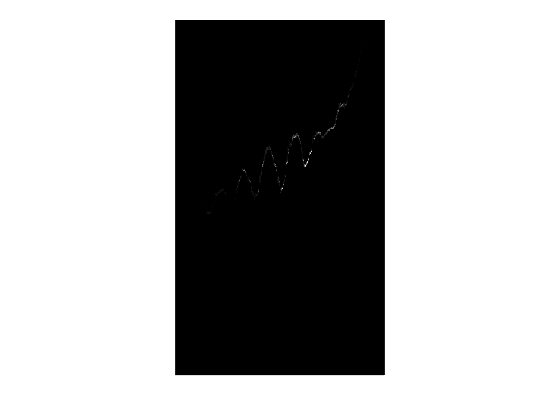

In [11]:
imshow(full(result).', [0, max(full(result), [], 'all')])

As expected, the image is taller now - we are visualizing frequencies at a more granular level.

`over` is essentially a measure of quality of the measurements we are taking. With `over = 1` we have a single scan line per pixel. With `over = 5` we move to 5 scan lines.

This is not something that we can easily visualize.

In [12]:
over = 4; % earlier we set over to 2
result = reassignmentgw(x, q, tdeci, over, noct, minf, maxf);

done_reassignment in 22.5399 s


As we perform double the calculations, our run time increases correspondingly.

To decrease the execution time and to remove the portions of the image where there doesn't seem to be too much information, can we visualize a narrower range of frequencies?

In [13]:
minf = 0.03; % earlier this was set to 0.02
result = reassignmentgw(x, q, tdeci, over, noct, minf, maxf);

done_reassignment in 14.2854 s


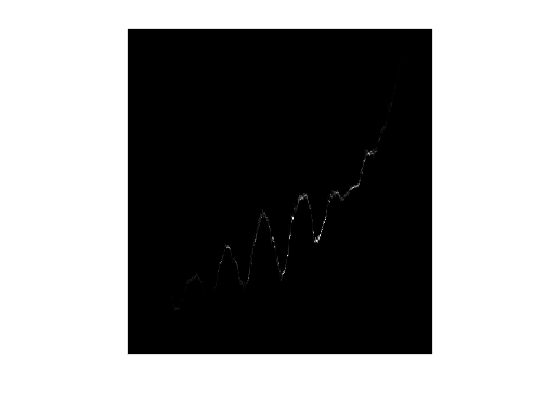

In [14]:
imshow(full(result).', [0, max(full(result), [], 'all')])

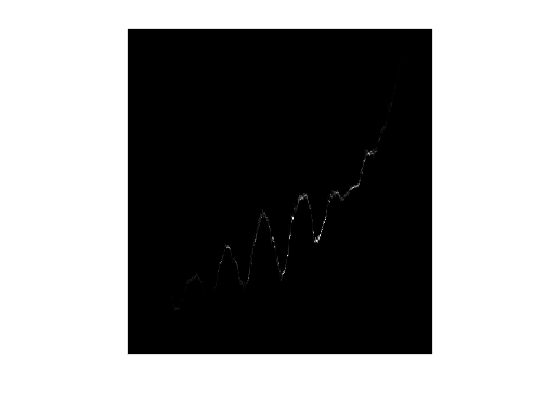

In [15]:
imshow(full(result).', [0, max(full(result), [], 'all')])

We got the result we were hoping for. Can we increase the granularity of us visualizing the frequencies? (essentially, can we increase the size of the image across the vertical dimension)

In [16]:
tdeci = 100; % earlier we skipped over 300 samples, this image should be 3.3 as wide as the previous one
result = reassignmentgw(x, q, tdeci, over, noct, minf, maxf);

done_reassignment in 14.2291 s


In [17]:
size(result)


ans =

   843   301



In [18]:
0.06 * sr


ans =

   960



We are looking at frequencies between 0.02 and 0.06, which in natural units are `0.02 * SR = 320` and `0.06 * sample_count = 960`. In real values that would equate to `1684 / sr = 